# 为什么你应该对冲贝塔和行业风险(第一部分)
by Jonathan Larkin and Maxwell Margenot

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

当我们有任何交易策略时，我们都需要考虑系统风险的影响。要想获得高于无风险利率的回报，投资策略中必须包含一些风险，但可以说，系统性风险会“毒化”这口井。从本质上讲，系统性风险为市场上众多无法分散投资的证券提供了共性。因此，我们需要建立一个对冲来摆脱它。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.covariance import LedoitWolf
import seaborn as sns
import statsmodels.api as sm

# 资产管理的基本定律

任何策略价值的主要驱动力是它是否提供了令人信服的经风险调整的回报，即夏普比率。正如Richard Grinold在[算法成功的基础](https://blog.quantopian.com/the-foundation-of-algo-success/)和“积极管理的基本法则”中所阐述的，夏普比率可以分解为两个组成部分，即技能和广度，即:

$$IR = IC \sqrt{BR}$$

从技术上讲，这是信息比率(IR)的定义，但就我们的目的而言，它相当于夏普比率。IR是指投资组合的超额回报与每单位主动风险的基准之比，即只做多的投资组合的超额回报减去每单位跟踪误差的基准。然而，在Grinold出版的时候，做多/做空投资是罕见的。如今，在对冲基金和做多/做空投资的世界里，没有基准。我们寻求绝对回报，在这种情况下，IR等于夏普比率。

在这个等式中，技能是通过IC(信息系数)来衡量的，通过[Alphalens](https://github.com/quantopian/alphalens)来计算。IC本质上是斯皮尔曼等级相关，用来关联你的预测和它的实现。宽度是衡量的数量**独立**押注期间。这个“定律”告诉我们，在任何策略中，我们都需要:

1. 打赌好(高IC)，
2. 经常下注(投注次数多)，
3. **使独立的押注**

如果投注是完全独立的，那么广度就是我们对每一项资产投注的总数，资产的数量乘以周期的数量。如果押注不是独立的，那么**有效宽度**可能远远小于资产数量。让我们精确地看看beta暴露和行业暴露对**有效宽度**有什么影响。

<div class="alert alert-warning">
<b>TL;DR:</b> 贝塔风险敞口和行业风险敞口导致了投注之间相关性的显著增加。带有beta和行业押注的投资组合的有效宽度非常低。为了拥有较高的夏普，这些投资组合的IC必须非常高。通过对冲贝塔系数和行业风险敞口来提高有效宽度，要比提高你的IC容易得多。
</div>

# 预测与赌注相关

我们将赌注定义为对证券回报的*残差*的预测。这种预测可能是隐含的，也就是说，我们买了一只股票，因此隐含地预测股票会上涨。我们所说的“残差”是什么意思呢?没有任何复杂的数学计算，这只是意味着回报**没有对冲**。让我们看三个例子。在所有情况下，我们使用“Ledoit-Wolf 协方差估计量”来评估我们的协方差。有关我们为什么使用ledoit - wolf而不是典型的样本协方差的更多信息，请查看[估计协方差矩阵](https://www.quantopian.com/lectures/estimating-covariance-matrices).

### 例1:没有对冲!

如果我们做多一套证券，但不持有任何空头头寸，就没有对冲!所以残差的就是股票回报本身。

$$r_{resid,i} = r_i$$

让我们看看在这种情况下我们赌注的相关性。

In [2]:
import yfinance as yf
tickers = ['WFC', 'JPM', 'USB', 'XOM', 'BKH', 'SLB'] # The securities we want to go long on
historical_prices = yf.download(tickers, '2015-01-01','2017-02-22') # Obtain prices
rets = historical_prices['Close'].pct_change().fillna(0) # Calculate returns
lw_cov = LedoitWolf().fit(rets).covariance_ # Calculate Ledoit-Wolf estimator

def extract_corr_from_cov(cov_matrix):
    # Linear algebra result:
    # https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    d = np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr = d.dot(cov_matrix).dot(d)
    return corr

[*********************100%***********************]  6 of 6 completed


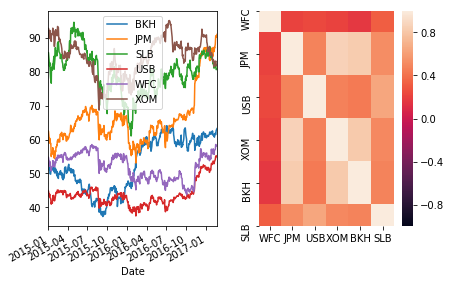

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
# Plot prices
left = historical_prices['Close'].plot(ax=ax1)
# Plot covariance as a heat map
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)

In [4]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print ('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.4822


结果是，我们有六个赌注，它们都是高度相关的。

### 例 2: β对冲

在这种情况下，我们将假设每个赌注都是针对市场(SPY)进行对冲的。在这种情况下，残差计算为:

$$ r_{resid,i} = r_i - \beta_i r_i $$

其中$\beta_i$是证券市场的beta，$i$是通过[CAPM](https://www.quantopian.com/lectures/the-capital-asset-pricing-model-and-arbitrage-pricing-theory)计算得到的，$r_i$是证券$i$的收益率。

In [5]:
tickers = ['WFC', 'JPM', 'USB', 'SPY', 'XOM', 'BKH', 'SLB' ] # The securities we want to go long on plus SPY
historical_prices = yf.download(tickers, '2015-01-01','2017-02-22')# Obtain prices
rets = historical_prices['Close'].pct_change().fillna(0) # Calculate returns

market = rets['SPY']
stock_rets = rets.drop(['SPY'], axis=1)
residuals = stock_rets.copy()*0

for stock in stock_rets.columns:
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    residuals[stock] = results.resid

lw_cov = LedoitWolf().fit(residuals).covariance_ # Calculate Ledoit-Wolf Estimator

[*********************100%***********************]  7 of 7 completed


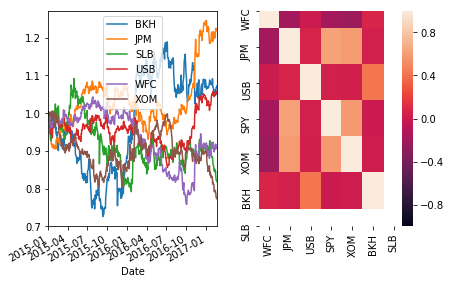

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
left = (1+residuals).cumprod().plot(ax=ax1)
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)

In [7]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print ('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.1246


贝塔对冲显著降低了平均相关系数。从理论上讲，这应该会提高我们的广度。然而，很明显，我们只剩下两个高度相关的集群。我们来看看对冲行业风险会发生什么。

### Example 3: 部门对冲

行业回报和市场回报本身是高度相关的。因此，由于多重共线性，你不能进行多元回归，这是一个经典的[违反回归假设](https://www.quantopian.com/lectures/violations-of-regression-models)。为了对冲市场和给定证券部门，您首先估计市场贝塔残差，然后根据*这些*剩余计算部门贝塔。

$$
r_{resid,i} = r_i - \beta_i r_i \\
r_{resid_{SECTOR},i}= r_{resid,i} - \beta_{SECTOR,i}r_{resid,i}
$$

这里$r_{resid, i}$是证券收益与市场贝塔对冲和之间的残差，$r_{resid_{SECTOR}, i}$是该残差与该残差针对相关部门的对冲之间的残差。

In [8]:
tickers = ['WFC', 'JPM', 'USB', 'XLF', 'SPY', 'XOM', 'BKH', 'SLB', 'XLE']
historical_prices = yf.download(tickers, '2015-01-01','2017-02-22')
rets = historical_prices['Close'].pct_change().fillna(0)

# Get market hedge ticker
mkt = ['SPY']
# Get sector hedge tickers
sector_1_hedge = ['XLF']
sector_2_hedge = ['XLE']
# Identify securities for each sector
sector_1_stocks = ['WFC', 'JPM', 'USB']
sector_2_stocks = ['XOM', 'BKH', 'SLB']

market_rets = rets[mkt]
sector_1_rets = rets[sector_1_hedge]
sector_2_rets = rets[sector_2_hedge]
          
stock_rets = rets.drop(['XLF', 'SPY', 'XLE'], axis=1)
residuals_market = stock_rets.copy()*0
residuals = stock_rets.copy()*0
# Calculate market beta of sector 1 benchmark
model = sm.OLS(sector_1_rets.values, market.values)
results = model.fit()
sector_1_excess = results.resid
# Calculate market beta of sector 2 benchmark
model = sm.OLS(sector_2_rets.values, market.values)
results = model.fit()
sector_2_excess = results.resid

for stock in sector_1_stocks:
    # Calculate market betas for sector 1 stocks
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], sector_1_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid
                           
for stock in sector_2_stocks:
    # Calculate market betas for sector 2 stocks
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], sector_2_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid

# Get covariance of residuals
lw_cov = LedoitWolf().fit(residuals).covariance_

[*********************100%***********************]  9 of 9 completed


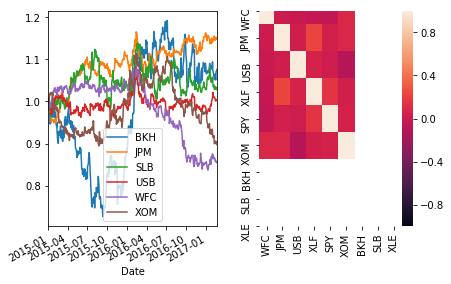

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
left = (1+residuals).cumprod().plot(ax=ax1)
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)

In [10]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print ('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.0387


我们走吧!行业对冲使得我们押注之间的相关性接近于零。

## 计算有效宽度

本节基于“如何计算宽度:主动投资组合管理基本法则的演变”，David Buckle, 2003年第4卷，第6期，393-405期，《资产管理杂志》。Buckle在若干弱假设下推导出了“主动管理的半广义基本定律”。本文(对我们来说)的关键结果是一个有效宽度的封闭形式的计算，它是投注之间相关性的函数。Buckle显示宽度，$BR$，可以建模为

$$BR = \frac{N}{1 + \rho(N -1)}$$

其中N是投资组合中的股票数量，$\rho$是预测周围的预期变化的假定单相关性。

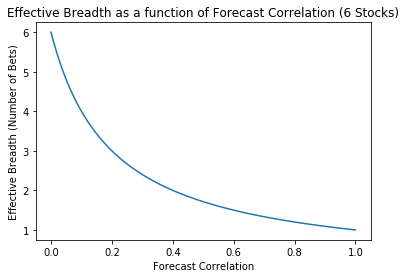

In [11]:
def buckle_BR_const(N, rho):
    return N/(1 + rho*(N - 1))

corr = np.linspace(start=0, stop=1.0, num=500)
plt.plot(corr, buckle_BR_const(6, corr))
plt.title('Effective Breadth as a function of Forecast Correlation (6 Stocks)')
plt.ylabel('Effective Breadth (Number of Bets)')
plt.xlabel('Forecast Correlation');

这里我们看到，在只做多的投资组合中，平均相关系数为0.56，我们实际上只下了大约2个赌注。当我们对冲贝塔系数时，结果的平均相关系数为0.22，情况会好一点，*三次有效押注*。当我们加上行业对冲，我们得到接近零的相关性，在这种情况下，投注的数量等于资产的数量，6。

**相同IC的独立投注越多，夏普比率越高**

## 在实践中使用

由于市场影响和佣金，交易要花钱。因此，对冲的事后实现几乎总是次优的。在这种情况下，你交易纯粹是为了对冲风险。在整个模型开发过程中，最好考虑您所在的行业和市场风险。行业和市场风险自然是通过成对策略进行对冲的;在一个横截面战略中，考虑去均值的阿尔法向量的扇区平均;使用事件驱动的策略，可以考虑添加额外的阿尔法，这样就可以在相同的部门中找到抵消赌注。作为最后的手段，选择一支精心挑选的行业ETF进行对冲。
